In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
def mod_wrap(x, a):
    return (x % a)

In [321]:
def rhs(point):
    x = point[0]
    y = point[1]
    
    f = 15 * np.sin(np.pi * x) * np.sin(np.pi * y)
    return f

In [322]:
def boundary_condition(points):
    x = points[:, 0]
    y = points[:, 1]
    
    g = (1 - x) * y * np.sin(np.pi * x)
    return g

In [3]:
def square_domain_boundary_condition(points):
    x = points[:, 0]
    y = points[:, 1]
    
    g = (1 - x) * y * np.sin(np.pi * x)
    
    return g

In [4]:
def square_domain_rhs(point):
    x = point[0]
    y = point[1]
    
    f = 15 * np.sin(np.pi * x) * np.sin(np.pi * y)
    return f

In [5]:
def L_domain_rhs(point):
    return 0

In [13]:
def L_domain_boundary_condition(points):
    x = points[:, 0]
    y = points[:, 1]
    
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    theta = ((theta >=0) * theta) + ((theta < 0) * (theta + (2 * np.pi)))
    g = (r**(2/3)) * np.sin(2*(theta - np.pi/2)/3)
    return g

In [364]:
a = np.random.randn(10)
(a > 0) * a

array([-0.        ,  1.6352085 ,  0.95621707,  1.8148469 , -0.        ,
       -0.        , -0.        ,  1.88101594, -0.        ,  0.58383575])

In [323]:
vertices = mesh['vertices']

In [324]:
[i[0].reshape(-1) - 1 for i in mesh['elements']]

[array([  0, 441,   1, 881,  22, 461,  21, 861], dtype=uint16),
 array([  1, 442,   2, 901,  23, 462,  22, 881], dtype=uint16),
 array([  2, 443,   3, 921,  24, 463,  23, 901], dtype=uint16),
 array([  3, 444,   4, 941,  25, 464,  24, 921], dtype=uint16),
 array([  4, 445,   5, 961,  26, 465,  25, 941], dtype=uint16),
 array([  5, 446,   6, 981,  27, 466,  26, 961], dtype=uint16),
 array([   6,  447,    7, 1001,   28,  467,   27,  981], dtype=uint16),
 array([   7,  448,    8, 1021,   29,  468,   28, 1001], dtype=uint16),
 array([   8,  449,    9, 1041,   30,  469,   29, 1021], dtype=uint16),
 array([   9,  450,   10, 1061,   31,  470,   30, 1041], dtype=uint16),
 array([  10,  451,   11, 1081,   32,  471,   31, 1061], dtype=uint16),
 array([  11,  452,   12, 1101,   33,  472,   32, 1081], dtype=uint16),
 array([  12,  453,   13, 1121,   34,  473,   33, 1101], dtype=uint16),
 array([  13,  454,   14, 1141,   35,  474,   34, 1121], dtype=uint16),
 array([  14,  455,   15, 1161,   36,  4

In [325]:
N_E = mesh['elements'][0][0].shape[0]

In [326]:
# elements = np.array([i[0].reshape(N_E) - 1 for i in mesh['elements']])

elements = np.array([i[0].reshape(-1) - 1 for i in mesh['elements']])


In [327]:
boundary = mesh['boundary'].T[0] - 1



In [328]:
n_dofs = vertices.shape[0]
n_polys = 3

In [329]:
K = np.zeros((n_dofs, n_dofs))

In [330]:
F = np.zeros(n_dofs)

In [331]:
u = np.zeros(n_dofs)

In [332]:
linear_polynomials = [[0, 0], [1, 0], [0, 1]]

In [333]:
for el_id in range(elements.shape[0]):
    
    vert_ids = elements[el_id]
    
    verts = vertices[vert_ids]
    
    n_sides = vert_ids.shape[0]
    
    area_components = verts[:, 0] * np.roll(verts[:, 1], -1) - np.roll(verts[:, 0], -1) * verts[:, 1]
    
    area = 0.5 * np.abs(np.sum(area_components))
    
    centroid = np.sum((np.roll(verts, -1, axis=0) + verts) * area_components.reshape(-1, 1), axis=0) / (6 * area)
    
    diameter = np.max(np.linalg.norm(verts - np.roll(verts, -1, axis=0), ord=2))
    
    D = np.zeros((n_sides, n_polys))
    D[:, 0] = 1
    
    B = np.zeros((n_polys, n_sides))
    B[0, :] = 1 / n_sides
    
    for vertex_id in range(n_sides):
        
        vert = verts[vertex_id, :]
        
        prevv = verts[mod_wrap(vertex_id - 1, n_sides), :]
        
        nextv = verts[mod_wrap(vertex_id + 1, n_sides), :]

        vertex_normal = np.array([nextv[1] - prevv[1], prevv[0] - nextv[0]])
        
        for poly_id in range(1, n_polys): # Looping over non-constant polynomials
            
            poly_degree = linear_polynomials[poly_id]
            
            monomial_grad = poly_degree / diameter
            
            D[vertex_id, poly_id] = np.dot(vert - centroid, poly_degree) / diameter
            B[poly_id, vertex_id] = np.dot(monomial_grad, vertex_normal) / 2

    projector = np.dot(np.linalg.inv(np.dot(B, D)), B)

    stabilising_term = np.dot((np.eye(n_sides) - np.dot(D, projector)).T, (np.eye(n_sides) - np.dot(D, projector))) 

    G = np.dot(B, D)
    G[0, :] = 0
   
    local_stiffness = np.dot(np.dot(projector.T, G), projector) + stabilising_term
    
    # Global indices
    gis = np.array(np.meshgrid(vert_ids, vert_ids)).T.reshape(-1,2).tolist()
    
    lsr = local_stiffness.ravel()
    counter = 0
    for i in range(len(gis)): 
        x = gis[i][0]
        y = gis[i][1]
        K[x, y] = K[x, y] + lsr[counter]
        counter+=1

    F[vert_ids] = F[vert_ids] + (rhs(centroid) * (area / n_sides))

boundary_vals = boundary_condition(vertices[boundary])
internal_dofs = np.array([i for i in np.arange(n_dofs) if i not in boundary])



F = F - np.dot(K[:, boundary], boundary_vals)



num_idof = internal_dofs.shape[0]
gid_of_idof = np.array(np.meshgrid(internal_dofs, internal_dofs)).T.reshape(-1,2).tolist()
K_II = np.zeros((num_idof, num_idof)).ravel()
counter = 0
for i in range(len(gid_of_idof)):
    x = gid_of_idof[i][0]
    y = gid_of_idof[i][1]
    
    K_II[counter] = K[x, y]
    counter+=1

K_II = K_II.reshape(num_idof, num_idof)
u[internal_dofs] = np.linalg.solve(K_II, F[internal_dofs])
u[boundary] = boundary_vals
    
    
    
    
    

In [14]:
def vem(mesh_file, rhs, boundary_condition):
    
    mesh = scipy.io.loadmat(mesh_file)
    
    vertices = mesh['vertices']
    
    elements = np.array([i[0].reshape(-1) - 1 for i in mesh['elements']])
    
    boundary = mesh['boundary'].T[0] - 1
    
    n_dofs = vertices.shape[0]
    n_polys = 3
    
    K = np.zeros((n_dofs, n_dofs))
    F = np.zeros(n_dofs)
    u = np.zeros(n_dofs)
    
    linear_polynomials = [[0, 0], [1, 0], [0, 1]]
    
    for el_id in range(elements.shape[0]):

        vert_ids = elements[el_id]

        verts = vertices[vert_ids]

        n_sides = vert_ids.shape[0]

        area_components = verts[:, 0] * np.roll(verts[:, 1], -1) - np.roll(verts[:, 0], -1) * verts[:, 1]

        area = 0.5 * np.abs(np.sum(area_components))

        centroid = np.sum((np.roll(verts, -1, axis=0) + verts) * area_components.reshape(-1, 1), axis=0) / (6 * area)

        diameter = np.max(np.linalg.norm(verts - np.roll(verts, -1, axis=0), ord=2))

        D = np.zeros((n_sides, n_polys))
        D[:, 0] = 1

        B = np.zeros((n_polys, n_sides))
        B[0, :] = 1 / n_sides

        for vertex_id in range(n_sides):

            vert = verts[vertex_id, :]

            prevv = verts[mod_wrap(vertex_id - 1, n_sides), :]

            nextv = verts[mod_wrap(vertex_id + 1, n_sides), :]

            vertex_normal = np.array([nextv[1] - prevv[1], prevv[0] - nextv[0]])

            for poly_id in range(1, n_polys): # Looping over non-constant polynomials

                poly_degree = linear_polynomials[poly_id]

                monomial_grad = poly_degree / diameter

                D[vertex_id, poly_id] = np.dot(vert - centroid, poly_degree) / diameter
                B[poly_id, vertex_id] = np.dot(monomial_grad, vertex_normal) / 2

        projector = np.dot(np.linalg.inv(np.dot(B, D)), B)

        stabilising_term = np.dot((np.eye(n_sides) - np.dot(D, projector)).T, (np.eye(n_sides) - np.dot(D, projector))) 

        G = np.dot(B, D)
        G[0, :] = 0

        local_stiffness = np.dot(np.dot(projector.T, G), projector) + stabilising_term

        # Global indices
        gis = np.array(np.meshgrid(vert_ids, vert_ids)).T.reshape(-1,2).tolist()

        lsr = local_stiffness.ravel()
        counter = 0
        for i in range(len(gis)): 
            x = gis[i][0]
            y = gis[i][1]
            K[x, y] = K[x, y] + lsr[counter]
            counter+=1

        F[vert_ids] = F[vert_ids] + (rhs(centroid) * (area / n_sides))

    boundary_vals = boundary_condition(vertices[boundary])
    internal_dofs = np.array([i for i in np.arange(n_dofs) if i not in boundary])



    F = F - np.dot(K[:, boundary], boundary_vals)



    num_idof = internal_dofs.shape[0]
    gid_of_idof = np.array(np.meshgrid(internal_dofs, internal_dofs)).T.reshape(-1,2).tolist()
    K_II = np.zeros((num_idof, num_idof)).ravel()
    counter = 0
    for i in range(len(gid_of_idof)):
        x = gid_of_idof[i][0]
        y = gid_of_idof[i][1]

        K_II[counter] = K[x, y]
        counter+=1

    K_II = K_II.reshape(num_idof, num_idof)
    u[internal_dofs] = np.linalg.solve(K_II, F[internal_dofs])
    u[boundary] = boundary_vals
    
    
    return u 
    
    

In [15]:
u = vem("../VirtualElementMethods/NA45/vem_50lines/meshes/L-domain.mat", L_domain_rhs, L_domain_boundary_condition)





In [35]:
def plot_solution(mesh, u, save=False, plot_name=None):

    vertices = mesh['vertices']
    elements = np.array([i[0].reshape(-1) - 1 for i in mesh['elements']])
    boundary = mesh['boundary'].T[0] - 1

    
    x = vertices[:, 0]
    y = vertices[:, 1]
    v = u


    plt.figure(figsize=(5, 5))
    ax = plt.subplot(111)
    xi = np.linspace(min(x) - 0.01, max(x) + 0.001, 100)
    yi = np.linspace(min(y) - 0.01, max(y) + 0.001, 100)
    
    
    
    zi = griddata((x, y), v, (xi[None,:], yi[:,None]), method='linear')
    print(zi)
    for i in range(len(elements)):

        for j in range(len(elements[i])):

            x = [vertices[elements[i][j%len(elements[i])]][0], vertices[elements[i][(j+1)%len(elements[i])]][0]]
            y = [vertices[elements[i][j%len(elements[i])]][1], vertices[elements[i][(j+1)%len(elements[i])]][1]]
            plt.plot(x, y, "k", linewidth=0.5)
    
    
    im = plt.pcolormesh(xi,yi,zi)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.set_title("Approximate Solution (u)")
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    if save and plot_name is not None:
        plt.savefig(plot_name)
    elif save and plot_name is None:
        plt.savefig("sol.png")
    
    plt.show()


In [18]:
mesh = scipy.io.loadmat('NA45/vem_50lines/meshes/L-domain.mat')

In [21]:
vertices = mesh['vertices']
elements = np.array([i[0].reshape(-1) - 1 for i in mesh['elements']])


[[       nan        nan        nan ...        nan        nan        nan]
 [       nan 1.25101299 1.24242486 ... 0.63037082 0.62704297        nan]
 [       nan 1.24246304 1.23346734 ... 0.61836056 0.6149564         nan]
 ...
 [       nan 0.63037208 0.61826583 ...        nan        nan        nan]
 [       nan 0.62701034 0.61484816 ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]]


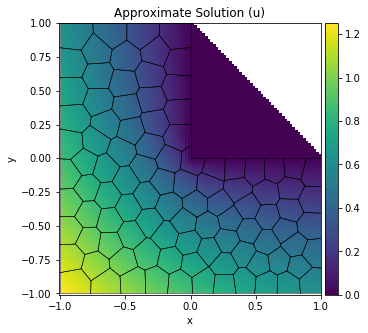

In [36]:
plot_solution(mesh, u)

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
[       nan 1.25101299 1.24242486 1.23391384 1.22540282 1.2168918
 1.20838078 1.19986976 1.19135874 1.18284772 1.1743367  1.16582568
 1.15731466 1.14893694 1.14056698 1.13219703 1.12382707 1.11545712
 1.10708716 1.09871721 1.09034725 1.0819773  1.07360734 1.06494275
 1.05659307 1.04852328 1.04045349 1.0323837  1.02431391 1.01624412
 1.00817433 1.00010454 0.99203475 0.98356408 0.97570922 0.96805852
 0.96040783 0.95275713 0.94510643 0.93745573 0.92980504 0.92215434
 0.91480806 0.90773683 0.9006656  0.89359437 0.88652314 0.87945191
 0.87238068 0.86530945 0.85823822 0.85155662 0.84516559 0.

In [39]:
for i in xi_test:
    if i in vertices[:, 0]:
        print(i)

In [40]:
xi_test

array([-1.01      , -0.98968687, -0.96937374, -0.94906061, -0.92874747,
       -0.90843434, -0.88812121, -0.86780808, -0.84749495, -0.82718182,
       -0.80686869, -0.78655556, -0.76624242, -0.74592929, -0.72561616,
       -0.70530303, -0.6849899 , -0.66467677, -0.64436364, -0.6240505 ,
       -0.60373737, -0.58342424, -0.56311111, -0.54279798, -0.52248485,
       -0.50217172, -0.48185859, -0.46154545, -0.44123232, -0.42091919,
       -0.40060606, -0.38029293, -0.3599798 , -0.33966667, -0.31935354,
       -0.2990404 , -0.27872727, -0.25841414, -0.23810101, -0.21778788,
       -0.19747475, -0.17716162, -0.15684848, -0.13653535, -0.11622222,
       -0.09590909, -0.07559596, -0.05528283, -0.0349697 , -0.01465657,
        0.00565657,  0.0259697 ,  0.04628283,  0.06659596,  0.08690909,
        0.10722222,  0.12753535,  0.14784849,  0.16816162,  0.18847475,
        0.20878788,  0.22910101,  0.24941414,  0.26972727,  0.2900404 ,
        0.31035354,  0.33066667,  0.3509798 ,  0.37129293,  0.39

In [41]:
vertices[:, 0]

array([-1.00000000e+00, -1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
       -3.43390075e-01,  1.00000000e+00,  3.80379854e-01,  8.24302020e-01,
        8.99120634e-01,  4.81240488e-01,  6.92477890e-01,  6.90718112e-01,
        8.42276130e-01,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  8.13811991e-01,  8.69072038e-01, -1.00000000e+00,
       -1.00000000e+00, -7.50793416e-01, -7.09179243e-01, -8.38512559e-01,
       -7.63263456e-01, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -8.83830422e-01, -8.10063180e-01, -6.17239912e-01,
       -5.40871075e-01,  1.47299336e-02, -3.43390075e-01, -1.76945394e-01,
        3.07380924e-01,  3.68328745e-01, -5.74268149e-02,  1.47299336e-02,
        1.02098398e-02, -1.76945393e-01, -1.64043523e-01, -7.65380547e-02,
        4.24361737e-01,  5.04933731e-01,  5.92350699e-01,  9.35389454e-01,
        8.52949353e-01,  

In [55]:
true = np.loadtxt("u_ld_l.txt")
calc = np.load("u_ld_l.npy")
abs_err = np.linalg.norm(true - calc, 2)
rel_err = abs_err / np.linalg.norm(true, 2)
abs_err, rel_err

(0.00013811600267027451, 1.4588291029695202e-05)